In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from ydata_profiling import ProfileReport

In [2]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
import geopandas as gpd

#import folium 
#from folium import plugins
#from folium.plugins import HeatMap

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

In [4]:
df = pd.read_csv('/Users/jdapeman/Documents/Kings_C_PROJECT/train_cleaned.csv')

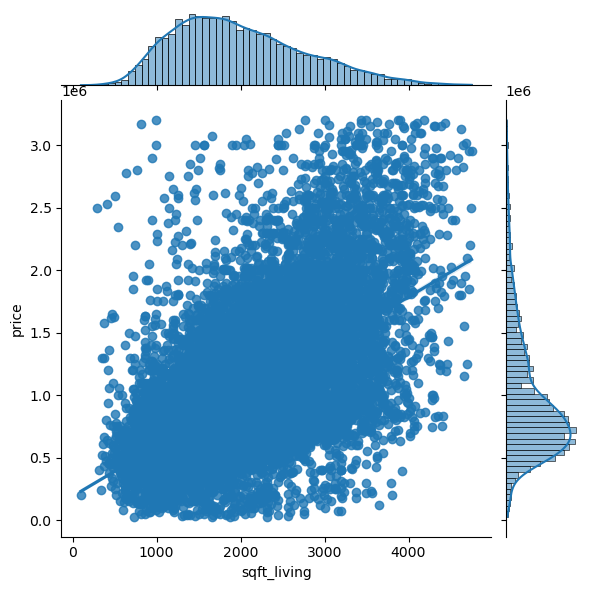

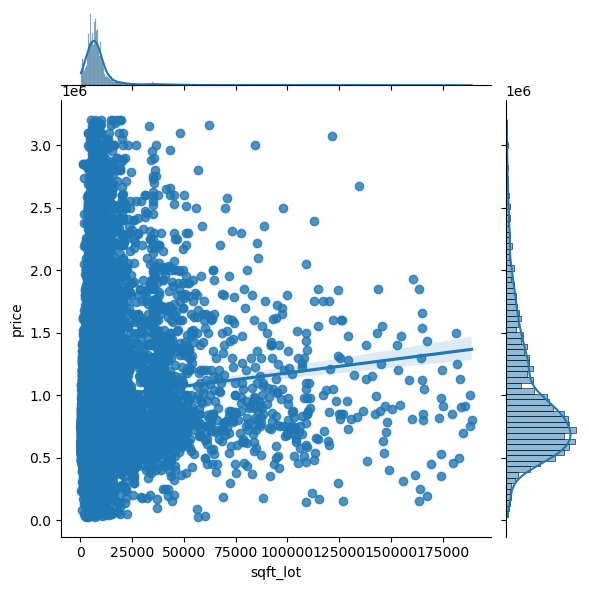

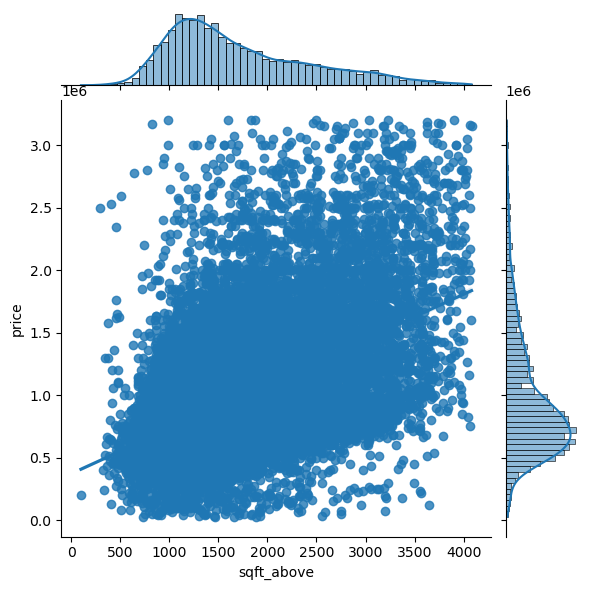

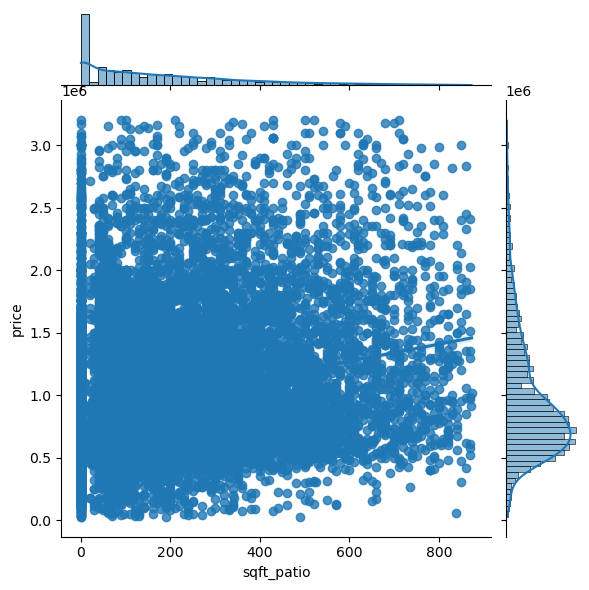

In [5]:
# We want to look at linearity of some select features vs our target variable, price
cont_feat = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_patio']


#  Plot jointplots
for feature in cont_feat:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

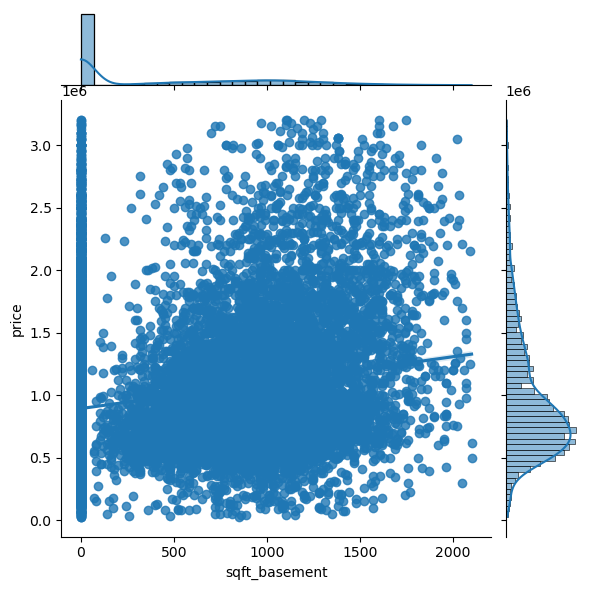

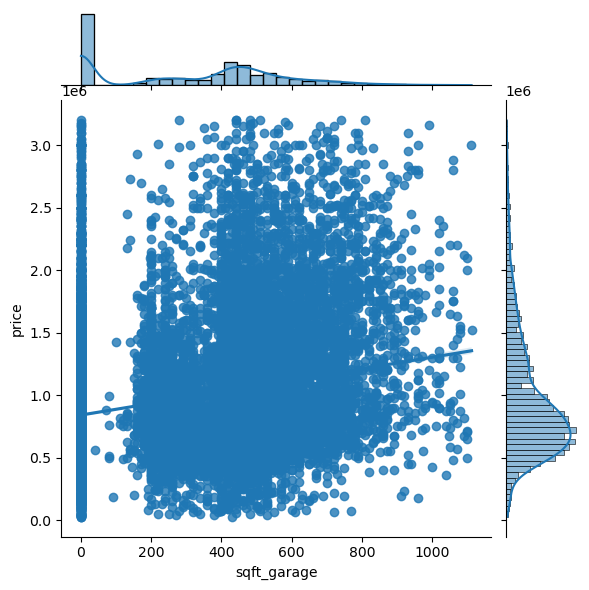

In [6]:
# let's look at linearity for some different continuous features

cont_feat_2 = ['sqft_basement', 'sqft_garage']


#  Plot jointplots
for feature in cont_feat_2:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

In [7]:
# we're getting really screwed up data due to the zeroes in the basement sq foot. we are unsure whether to leave this
# column and calculate its mean, or create a new column of the mean with just those places that have a basement

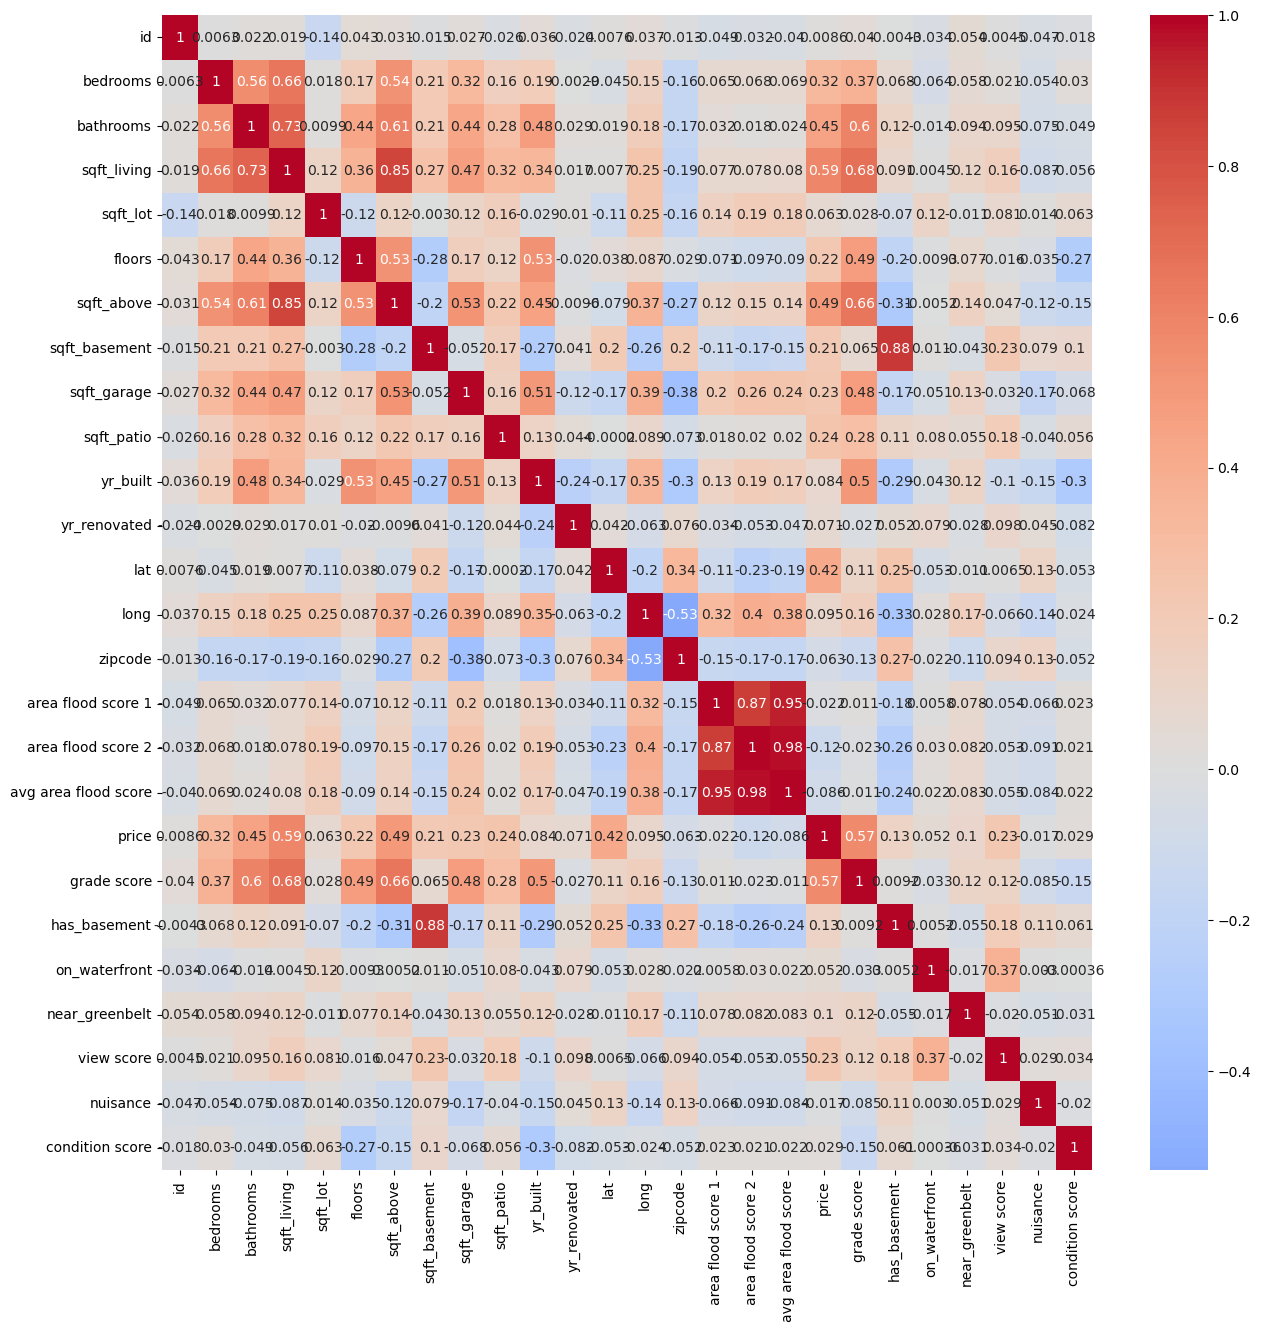

In [8]:
# done with continuous variables, so let's look again at multicollinearity using heatmaps

corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [9]:
# gonna drop sq_basement, since it is so highly correlated with "has_basement" AND so few have basements that it
# really skews the mean

In [10]:
df.drop(labels='sqft_basement', axis=1, inplace=True)

In [11]:
# sqft_above is also fairly strongly correlated AND isn't super-relevant for our purposes
df.drop(labels='sqft_above', axis=1, inplace=True)

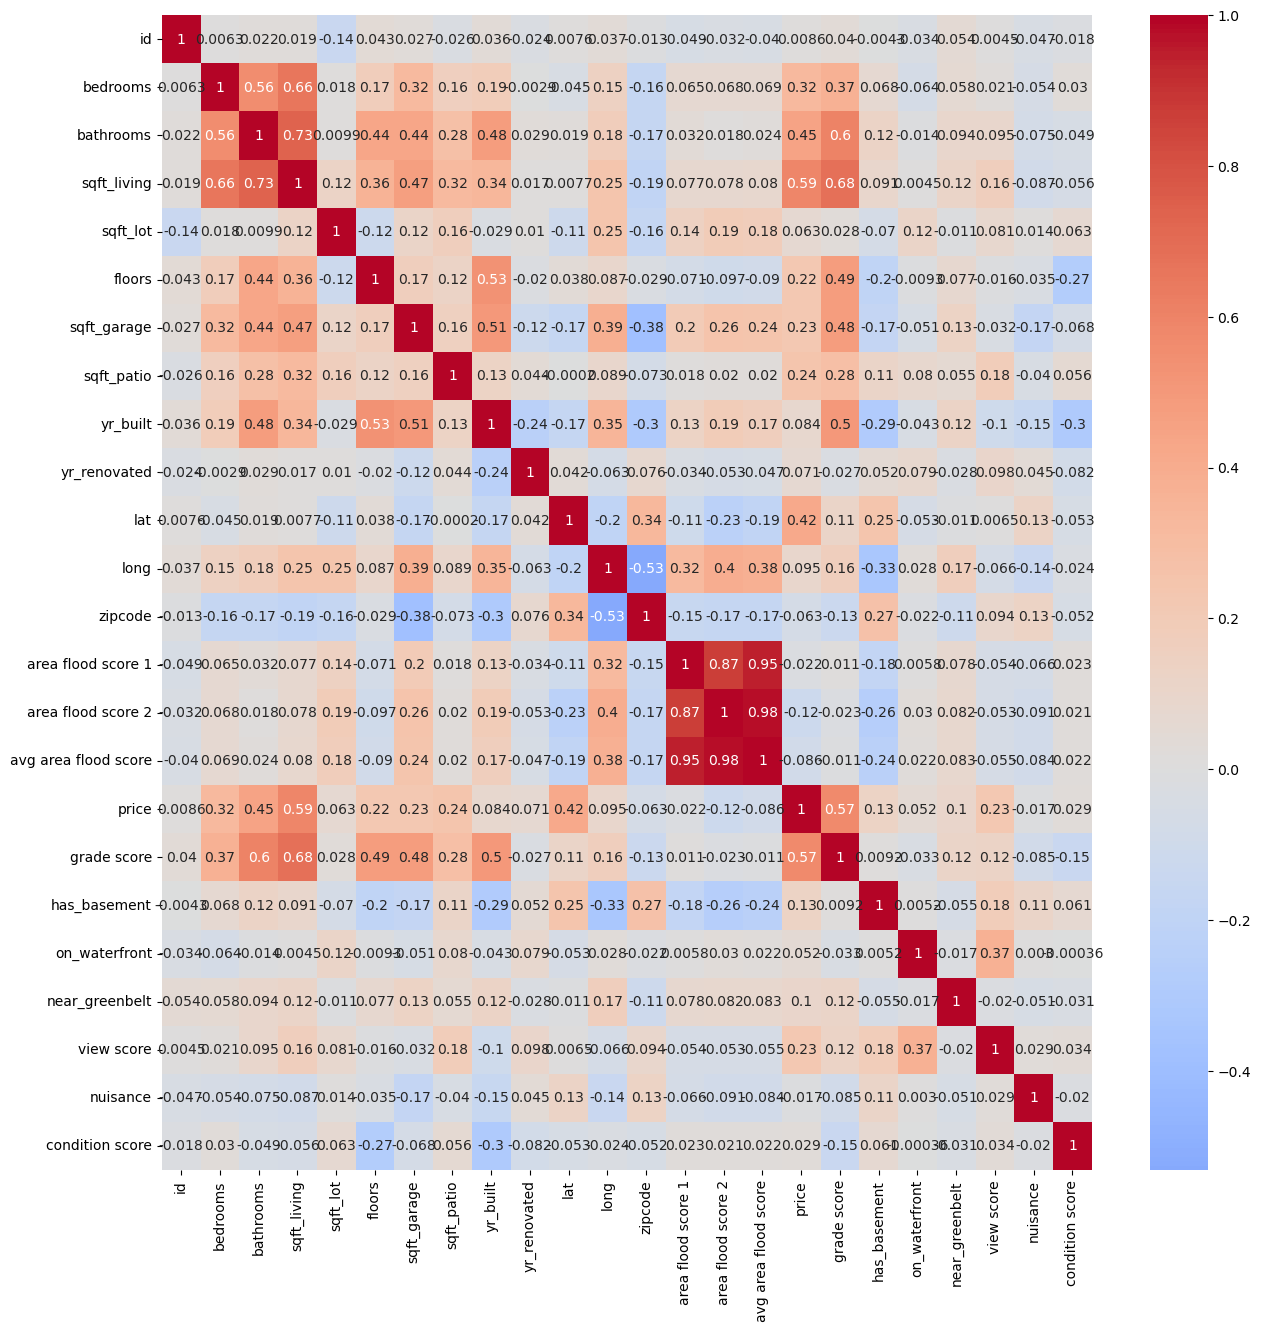

In [12]:
#let's get a new heatmap

new_corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(new_corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [13]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# https://www.statology.org/how-to-calculate-vif-in-python/

y, X = dmatrices('sqft_living ~ bedrooms+bathrooms', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,15.868828,Intercept
1,1.447613,bedrooms
2,1.447613,bathrooms


In [14]:
# our VIF scores aren't bad (2-5 is moderate). let's try this again for a few other variables

In [15]:
df.rename(columns={'area flood score 1': 'area_flood_score_max', 'area flood score 2':'area_flood_score_min', 
                   'avg area flood score':'avg_area_flood_score'}, inplace=True)

In [16]:
df.rename(columns={'floodzones in zipcode': 'floodzones_in_zipcode'}, inplace=True)

In [17]:
y, X = dmatrices('area_flood_score_max ~  area_flood_score_min+avg_area_flood_score', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,94.865676,Intercept
1,27.516518,area_flood_score_min
2,27.516518,avg_area_flood_score


In [18]:
# very high VIF scores for our flood data, but should we drop? unsure how to handle
# overall, VIF scores are superior to correlation data, per https://online.stat.psu.edu/stat462/node/180/

In [19]:
#gonna leave them for now. resaving this training data

df.to_csv('cleaned_training_2.csv')

In [20]:
df_2 = pd.read_csv('/Users/jdapeman/Documents/Kings_C_PROJECT/cleaned_training_2.csv')

In [21]:
# somehow didn't drop sewer and heat source in this new csv? dropping now

df_2.drop(columns=['sewer_system', 'heat_source'], axis=1, inplace=True)

In [22]:
df_2.head()

,Unnamed: 0,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,...,area_flood_score_min,avg_area_flood_score,price,grade score,has_basement,on_waterfront,near_greenbelt,view score,nuisance,condition score
0,0,3873900250,2021-07-19,3,1.5,1420,10364,1.0,380,0,...,2.200000,2.30,460000.0,7,0,0,0,0,0,4
1,1,627300085,2021-12-07,4,3.0,4100,10400,1.0,0,460,...,2.200000,2.30,2205000.0,8,1,0,0,4,0,4
2,2,8682230800,2021-09-27,2,2.5,2170,6853,1.0,580,200,...,2.333333,2.50,1500000.0,8,0,0,0,0,0,3
3,3,3629980690,2021-06-10,4,2.5,2310,3830,2.0,470,50,...,2.000000,2.25,1250000.0,9,0,0,0,0,0,3
4,4,8651430370,2022-04-29,4,1.0,1240,5200,1.0,0,80,...,2.333333,2.50,500000.0,6,0,0,0,0,0,5


In [23]:
X_train = np.array(df_2['sqft_living']).reshape(-1, 1)
y_train = df_2['price']
X_train

array([[1420],
       [4100],
       [2170],
       ...,
       [1350],
       [2280],
       [2310]])

In [24]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     9963.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:26   Log-Likelihood:            -2.7039e+05
No. Observations:               18805   AIC:                         5.408e+05
Df Residuals:                   18803   BIC:                         5.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.912e+05   8555.227     22.344      0.000    1.74e+05    2.08e+05
x1           398.6513      3.994     99.814      0.000     390.823     406.480
==============================================================================
Omnibus:                     2978.417   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6635.753
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                       5.239   Cond. No.                     5.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Evaluate using rmse
scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)
# ValueError: Expected 2D array, got 1D array instead:
#array=[1420 4100 2170 ... 1350 2280 2310].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [26]:
rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([430212.88732604, 413830.22610237, 413826.78355632, 428375.49507535,
       399822.19911496, 429580.77429805, 442918.94344847, 426369.32100764,
       439013.77179312, 423010.93696681])

424696.1338689125

12105.619877439343

In [27]:
# mean error is 424k! std is 12105. that's pretty large. we can imagine this would happen because
# king county is so large and has a lot of variation. small places in seattle would sell for a lot more
# than large places in less-desirable areas. let's add more features

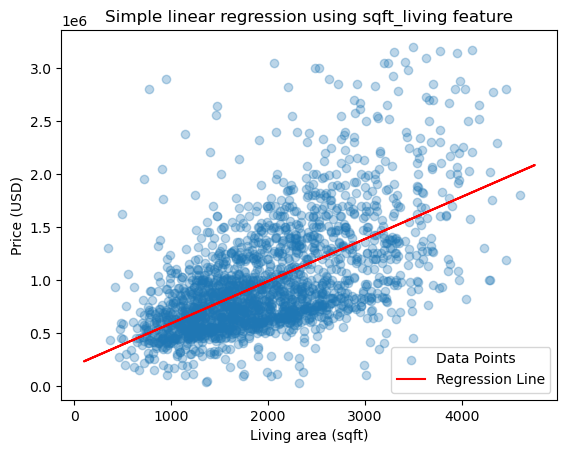

In [28]:
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'red', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_living feature')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()

In [29]:
#where did this unnamed column come from? let's get rid of it
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [30]:
# so size isn't super-relevant for king county. let's look at area. we need to drop all area info in 
# order to get our base model. let's also remove object data, since the model can't handle it
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date'], axis=1)
y_train = df_2['price']

In [31]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     972.6
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:30   Log-Likelihood:            -2.6794e+05
No. Observations:               18805   AIC:                         5.359e+05
Df Residuals:                   18785   BIC:                         5.361e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.207e+06 

In [32]:
#well, our model isn't very predictive. probably due to the multicollinearity with the flood data? look at "cond. no."

##let's try removing it


In [33]:
X_train = df_2.drop(['area_flood_score_min','area_flood_score_max', 'avg_area_flood_score','price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date', ], axis=1)
y_train = df_2['price']

In [34]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     994.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:32   Log-Likelihood:            -2.6835e+05
No. Observations:               18805   AIC:                         5.367e+05
Df Residuals:                   18787   BIC:                         5.369e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.838e+06    2.7e+05     

In [35]:
# that made it worse!! let's re-add those (and convert objects to categoricals)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18805 entries, 0 to 18804
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     18805 non-null  int64  
 1   date                   18805 non-null  object 
 2   bedrooms               18805 non-null  int64  
 3   bathrooms              18805 non-null  float64
 4   sqft_living            18805 non-null  int64  
 5   sqft_lot               18805 non-null  int64  
 6   floors                 18805 non-null  float64
 7   sqft_garage            18805 non-null  int64  
 8   sqft_patio             18805 non-null  int64  
 9   yr_built               18805 non-null  int64  
 10  yr_renovated           18805 non-null  int64  
 11  lat                    18805 non-null  float64
 12  long                   18805 non-null  float64
 13  street address         18805 non-null  object 
 14  city                   18805 non-null  object 
 15  zi

In [36]:
df_2['street address'] = df_2['street address'].astype('category')
df_2['city'] = df_2['city'].astype('category')
df_2['floodzones_in_zipcode'] = df_2['floodzones_in_zipcode'].astype('category')

In [37]:
df_2.drop(columns=['id', 'date'], axis=1, inplace=True)

In [38]:
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode' ], axis=1)
y_train = df_2['price']

In [39]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1027.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:35   Log-Likelihood:            -2.6794e+05
No. Observations:               18805   AIC:                         5.359e+05
Df Residuals:                   18786   BIC:                         5.361e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.201e+06 

In [40]:
# let's boost this by just looking at one flood score at a time

X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'area_flood_score_max'], axis=1)
y_train = df_2['price']

In [41]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     1009.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:36   Log-Likelihood:            -2.6828e+05
No. Observations:               18805   AIC:                         5.366e+05
Df Residuals:                   18787   BIC:                         5.367e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.579e+06 

In [42]:
#worse! 


X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_min', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']

In [43]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     994.6
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:37   Log-Likelihood:            -2.6835e+05
No. Observations:               18805   AIC:                         5.367e+05
Df Residuals:                   18787   BIC:                         5.369e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.821e+06 

In [44]:
# even worse! finally, let's remove the max and area score
#(note, however, that our cond no. scores are dropping)

X_train = df_2.drop(['price','lat', 'long', 'zipcode',  'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = df_2['price']


In [45]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1025.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:38   Log-Likelihood:            -2.6821e+05
No. Observations:               18805   AIC:                         5.365e+05
Df Residuals:                   18787   BIC:                         5.366e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.294e+06 

In [46]:
#better! min score is more predictive!, with the same cond no. 

In [47]:
#let's do some onehot encoding

def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [48]:
onehot_df = one_hot_encode(df_2, ['grade score', 'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance'])
onehot_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,...,grade score_11,grade score_12,has_basement_1,on_waterfront_1,near_greenbelt_1,view score_1,view score_2,view score_3,view score_4,nuisance_1
0,3,1.5,1420,10364,1.0,380,0,1961,0,47.343920,...,0,0,0,0,0,0,0,0,0,0
1,4,3.0,4100,10400,1.0,0,460,1958,0,47.586060,...,0,0,1,0,0,0,0,0,1,0
2,2,2.5,2170,6853,1.0,580,200,2004,0,47.710940,...,0,0,0,0,0,0,0,0,0,0
3,4,2.5,2310,3830,2.0,470,50,2006,0,47.553735,...,0,0,0,0,0,0,0,0,0,0
4,4,1.0,1240,5200,1.0,0,80,1969,0,47.370090,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#let's try linear and mulilinear with this onehot encoded values

In [50]:
X_train = onehot_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df['price']

In [51]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     622.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:42   Log-Likelihood:            -2.6789e+05
No. Observations:               18805   AIC:                         5.359e+05
Df Residuals:                   18774   BIC:                         5.361e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  7.85e+06   3.76e+05     20.852      0.000    7.11e+06    8.59e+06
bedrooms             -2.081e+04   4248.183     -4.899      0.000   -2.91e+04   -1.25e+04
bathrooms             5.744e+04   6047.317      9.499      0.000    4.56e+04    6.93e+04
sqft_living            228.9386      6.956     32.914      0.000     215.305     242.572
sqft_lot                -0.0984      0.187     -0.525      0.599      -0.465       0.269
floors               -2.425e+04   6942.293     -3.493      0.000   -3.79e+04   -1.06e+04
sqft_garage            -39.5188     14.303     -2.763      0.006     -67.554     -11.484
sqft_patio              34.8248     15.855      2.196      0.028       3.747      65.903
yr_built             -3373.4984    139.539    -24.176      0.000   -3647.008   -3099.989
yr_renovated            19.0432      7.111      2.678      0.007       5.105      32.981
area_flood_score_min -1.048e+05   6031.847    -17.367      0.000   -1.17e+05   -9.29e+04
condition score       4.208e+04   4240.833      9.922      0.000    3.38e+04    5.04e+04
grade score_2        -7.475e+05   4.57e+05     -1.635      0.102   -1.64e+06    1.49e+05
grade score_3        -9.423e+05   2.99e+05     -3.151      0.002   -1.53e+06   -3.56e+05
grade score_4        -8.678e+05   2.71e+05     -3.203      0.001    -1.4e+06   -3.37e+05
grade score_5        -9.155e+05   2.65e+05     -3.456      0.001   -1.43e+06   -3.96e+05
grade score_6        -9.079e+05   2.64e+05     -3.437      0.001   -1.43e+06    -3.9e+05
grade score_7        -7.879e+05   2.64e+05     -2.982      0.003   -1.31e+06    -2.7e+05
grade score_8        -5.769e+05   2.64e+05     -2.182      0.029    -1.1e+06   -5.88e+04
grade score_9        -2.581e+05   2.65e+05     -0.975      0.329   -7.77e+05    2.61e+05
grade score_10        4.546e+04   2.65e+05      0.172      0.864   -4.74e+05    5.65e+05
grade score_11         1.79e+05   2.68e+05      0.668      0.504   -3.46e+05    7.04e+05
grade score_12        5.041e+05   2.92e+05      1.724      0.085    -6.9e+04    1.08e+06
has_basement_1       -7684.9752   6512.921     -1.180      0.238   -2.05e+04    5080.939
on_waterfront_1       3.955e+04   2.94e+04      1.347      0.178    -1.8e+04    9.71e+04
near_greenbelt_1      1.371e+05   1.76e+04      7.797      0.000    1.03e+05    1.72e+05
view score_1          1.332e+05   3.32e+04      4.011      0.000    6.81e+04    1.98e+05
view score_2          5.295e+04   1.19e+04      4.465      0.000    2.97e+04    7.62e+04
view score_3          1.024e+05   1.87e+04      5.471      0.000    6.57e+04    1.39e+05
view score_4          3.337e+05   2.85e+04     11.720      0.000    2.78e+05     3.9e+05
nuisance_1             1.07e+04   7399.810      1.446      0.148   -3807.813    2.52e+04
=========================================================

In [52]:
# well, we got a tiny R2 improvement, though cond no increased. maybe we need more one-hot encoding?

In [53]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([387005.74726818, 361779.41872946, 357155.39413752, 374159.39310815,
       349719.70760921, 382163.29647085, 392429.01886304, 371982.87874244,
       385283.15825634, 368794.70339811])

373047.27165832877

13219.136143165073

In [54]:
# our RMSE scores improved in one respect but the std increased

In [55]:
# let's try onehot encoding more

In [56]:
catcols = ['bedrooms', 'bathrooms', 'floors']

In [57]:
onehot_df_2 = one_hot_encode(onehot_df, catcols)

In [58]:
X_train = onehot_df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_df_2['price']

In [59]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     401.2
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:47   Log-Likelihood:            -2.6784e+05
No. Observations:               18805   AIC:                         5.358e+05
Df Residuals:                   18757   BIC:                         5.362e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.677e+06   4.01e+05     19.164      0.000    6.89e+06    8.46e+06
sqft_living            225.0149      7.089     31.742      0.000     211.120     238.910
sqft_lot                -0.0462      0.187     -0.246      0.805      -0.413       0.321
sqft_garage            -24.1415     14.681     -1.644      0.100     -52.918       4.635
sqft_patio              36.2286     15.905      2.278      0.023       5.052      67.405
yr_built             -3398.9182    148.774    -22.846      0.000   -3690.528   -3107.308
yr_renovated            18.6837      7.122      2.623      0.009       4.724      32.643
area_flood_score_min -1.031e+05   6037.337    -17.076      0.000   -1.15e+05   -9.13e+04
condition score       4.592e+04   4273.638     10.746      0.000    3.75e+04    5.43e+04
grade score_2        -9.233e+05   4.64e+05     -1.991      0.047   -1.83e+06   -1.41e+04
grade score_3        -9.737e+05   3.01e+05     -3.238      0.001   -1.56e+06   -3.84e+05
grade score_4        -9.947e+05   2.82e+05     -3.528      0.000   -1.55e+06   -4.42e+05
grade score_5         -1.02e+06   2.78e+05     -3.669      0.000   -1.56e+06   -4.75e+05
grade score_6         -9.84e+05   2.78e+05     -3.543      0.000   -1.53e+06    -4.4e+05
grade score_7        -8.405e+05   2.78e+05     -3.025      0.002   -1.39e+06   -2.96e+05
grade score_8        -6.258e+05   2.78e+05     -2.251      0.024   -1.17e+06    -8.1e+04
grade score_9        -3.178e+05   2.78e+05     -1.142      0.253   -8.63e+05    2.27e+05
grade score_10       -2.472e+04   2.79e+05     -0.089      0.929   -5.71e+05    5.21e+05
grade score_11        9.707e+04   2.82e+05      0.345      0.730   -4.55e+05    6.49e+05
grade score_12        4.095e+05   3.05e+05      1.344      0.179   -1.88e+05    1.01e+06
has_basement_1       -6618.3275   6585.345     -1.005      0.315   -1.95e+04    6289.545
on_waterfront_1       3.782e+04   2.94e+04      1.288      0.198   -1.97e+04    9.54e+04
near_greenbelt_1      1.386e+05   1.76e+04      7.882      0.000    1.04e+05    1.73e+05
view score_1          1.325e+05   3.32e+04      3.997      0.000    6.75e+04    1.97e+05
view score_2          5.075e+04   1.18e+04      4.285      0.000    2.75e+04     7.4e+04
view score_3          9.703e+04   1.87e+04      5.189      0.000    6.04e+04    1.34e+05
view score_4          3.345e+05   2.84e+04     11.767      0.000    2.79e+05     3.9e+05
nuisance_1            8272.2010   7399.852      1.118      0.264   -6232.178    2.28e+04
bedrooms_2           -9.411e+04   2.64e+04     -3.571      0.000   -1.46e+05   -4.24e+04
bedrooms_3           -1.146e+05   2.66e+04     -4.318      0.000   -1.67e+05   -6.26e+04
bedrooms_4           -1.302e+05   2.74e+04     -4.748      0.000   -1.84e+05   -7.65e+04
bedrooms_5           -1.401e+05   2.93e+04     -4.777    

In [60]:
# we've inched up, but not by much. we still have a lot of multicollinearity. clearly area matters but there's
#maybe too much variety within a zipcode
# let's try getting neighborhood data using geo location

In [61]:
def neighborhood_feat(df):
   
    
    # Define coord column with lat and long
    df['coord'] = list(zip(df['lat'], df['long']))
    
    # Use reverse geocoder
    results = rg.search(list(df['coord']))
    
    # Define neighbourhood list
    neighborhoods = [results[i]['name'] for i in range(0, len(results))]
    
    # Add neighbourhood feature
    df['neighborhood'] = neighborhoods
    
    return df

In [62]:
neighborhood_df = onehot_df_2.copy()

In [63]:
neighborhood_df = neighborhood_feat(neighborhood_df)

Loading formatted geocoded file...


In [64]:
#neighborhood_df = neighborhood_df .drop(['coord', 'lat', 'long', 'zipcode'], axis = 1)
# dropping multicollinearity features
onehot_neighborhood_df = one_hot_encode(neighborhood_df, 'neighborhood')
# Check 


In [65]:
onehot_neighborhood_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18805 entries, 0 to 18804
Columns: 135 entries, sqft_living to Yarrow Point
dtypes: category(3), float64(6), int64(8), object(1), uint8(117)
memory usage: 5.0+ MB


In [66]:
# well, that hardly helped. what is going on here? 

from geopy.distance import geodesic

In [67]:
seattle_lat = 47.6097
seattle_lon = -122.3331


In [68]:
onehot_neighborhood_df['distance from Seattle'] = onehot_neighborhood_df.apply(lambda row: geodesic((seattle_lat, seattle_lon), (row['lat'], row['long'])).miles, axis=1)

In [69]:
onehot_neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city',
       ...
       'Tanner', 'Tukwila', 'Union Hill-Novelty Hill', 'Vashon',
       'West Lake Sammamish', 'White Center', 'Woodinville', 'Woodway',
       'Yarrow Point', 'distance from Seattle'],
      dtype='object', length=136)

In [70]:
X_train = onehot_neighborhood_df.drop(['price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['price']

In [71]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [72]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     389.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:50:57   Log-Likelihood:            -2.6227e+05
No. Observations:               18805   AIC:                         5.248e+05
Df Residuals:                   18678   BIC:                         5.258e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.169e+06   3.15e+05      6.897      0.000    1.55e+06    2.79e+06
sqft_living                 239.6550      5.393     44.434      0.000     229.083     250.227
sqft_lot                      1.2590      0.153      8.220      0.000       0.959       1.559
sqft_garage                  61.8228     11.507      5.372      0.000      39.267      84.378
sqft_patio                   43.4637     11.968      3.632      0.000      20.006      66.922
yr_built                   -740.9115    118.955     -6.229      0.000    -974.074    -507.750
yr_renovated                 33.8617      5.340      6.341      0.000      23.395      44.329
area_flood_score_min      -1.263e+04   6885.550     -1.834      0.067   -2.61e+04     868.402
condition score            6.032e+04   3237.899     18.631      0.000     5.4e+04    6.67e+04
grade score_2             -9.238e+05   3.56e+05     -2.594      0.010   -1.62e+06   -2.26e+05
grade score_3             -5.371e+05   2.25e+05     -2.385      0.017   -9.79e+05   -9.56e+04
grade score_4             -5.794e+05   2.11e+05     -2.743      0.006   -9.93e+05   -1.65e+05
grade score_5             -6.546e+05   2.08e+05     -3.143      0.002   -1.06e+06   -2.46e+05
grade score_6             -6.872e+05   2.08e+05     -3.302      0.001    -1.1e+06   -2.79e+05
grade score_7              -6.66e+05   2.08e+05     -3.200      0.001   -1.07e+06   -2.58e+05
grade score_8             -5.641e+05   2.08e+05     -2.709      0.007   -9.72e+05   -1.56e+05
grade score_9             -3.795e+05   2.08e+05     -1.821      0.069   -7.88e+05    2.89e+04
grade score_10            -2.045e+05   2.09e+05     -0.980      0.327   -6.14e+05    2.05e+05
grade score_11            -5.449e+04   2.11e+05     -0.258      0.796   -4.68e+05    3.59e+05
grade score_12              2.47e+05   2.28e+05      1.083      0.279      -2e+05    6.94e+05
has_basement_1             -6.75e+04   5248.741    -12.861      0.000   -7.78e+04   -5.72e+04
on_waterfront_1            1.434e+05   2.25e+04      6.388      0.000    9.94e+04    1.87e+05
near_greenbelt_1           5.412e+04   1.36e+04      3.992      0.000    2.75e+04    8.07e+04
view score_1               1.447e+05   2.49e+04      5.801      0.000    9.58e+04    1.94e+05
view score_2                8.36e+04   8968.916      9.321      0.000     6.6e+04    1.01e+05
view score_3               1.571e+05   1.41e+04     11.124      0.000    1.29e+05    1.85e+05
view score_4               4.171e+05   2.14e+04     19.508      0.000    3.75e+05    4.59e+05
nuisance_1                -3.411e+04   5579.117     -6.114      0.000    -4.5e+04   -2.32e+04
bedrooms_2                 -5.07e+04   1.97e+04     -2.568      0.010   -8.94e+04    -1.2e+04
bedrooms_3                -1.053e+04   1.99e+04     -0.528      0.597   -4.

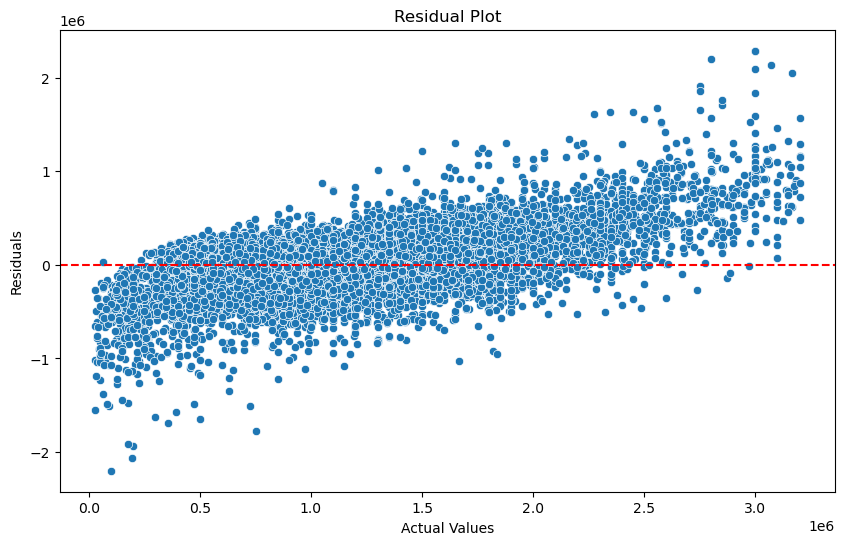

In [73]:
#well, this one variable is sorta powerful! neighborhood made all the difference


# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 1000x600 with 0 Axes>

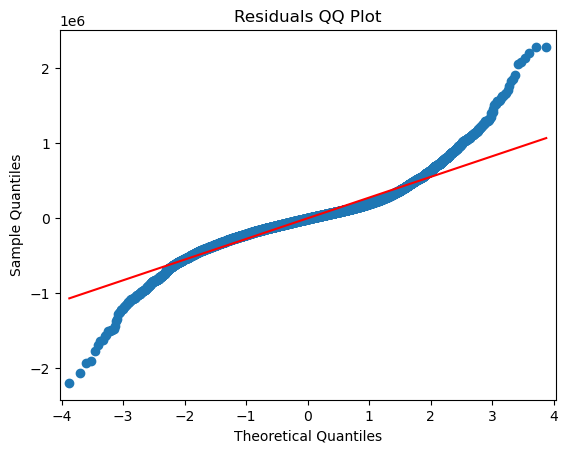

In [74]:
import statsmodels.graphics.gofplots as smg
residuals = model.resid

# Create a residuals QQ plot using statsmodels and matplotlib
plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

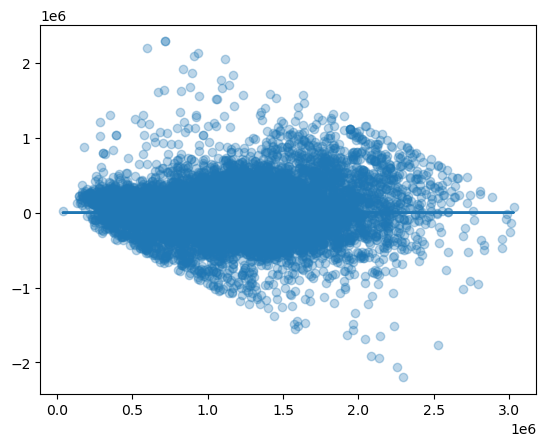

In [75]:
# our residuals still aren't great but let's check another aspect - homo- vs. heteroscedasticity

plt.scatter(model.predict(X_int), model.resid, alpha = 0.3)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()


In [76]:
# should we go back and log transform? probably in an ideal world, but this isn't too bad
# but let's experiment really quickly:

#price = neighborhood_df['price']
neighborhood_df['log_price'] = price

# Print the transformed data
print(log_price)

NameError: name 'price' is not defined

In [77]:
#let's add this to the onehot model!

onehot_neighborhood_df['log_price'] = price

# Print the transformed data
print(log_price)

NameError: name 'price' is not defined

In [78]:
X_train = onehot_neighborhood_df.drop(['log_price','price','lat', 'long', 'zipcode', 'street address', 'coord', 'city', 'floodzones_in_zipcode', 'area_flood_score_max', 'avg_area_flood_score'], axis=1)
y_train = onehot_neighborhood_df['log_price']

KeyError: "['log_price'] not found in axis"

In [ ]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

In [ ]:
# well, our R2 is sthe same. cond isn't much better. let's look at residuals!
# let's visualize this successful R2 model, that added neighborhoods using onehot encoding!:
    
residuals = model.resid

# Create a residual plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 1000x600 with 0 Axes>

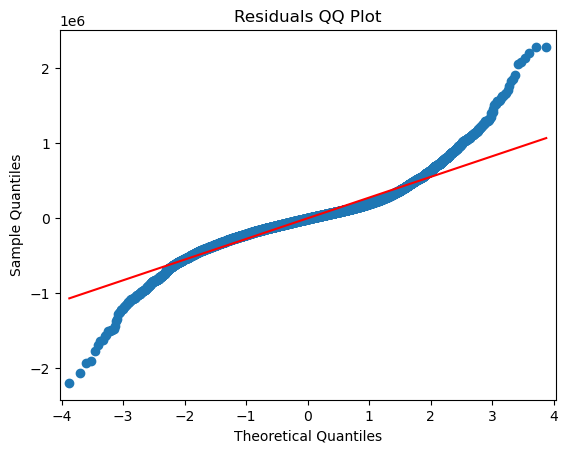

In [79]:
# log transform didn't do much. one last residual plot:

plt.figure(figsize=(10, 6))
smg.qqplot(residuals, line='s')
plt.title('Residuals QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [80]:
# pretty much identical. let's get rid of log price

neighborhood_df.drop('log_price', axis= 1, inplace=True)
onehot_neighborhood_df.drop('log_price', axis= 1, inplace=True)

KeyError: "['log_price'] not found in axis"

In [81]:
# these are the top median neighborhoods by price 


test = neighborhood_df.groupby(neighborhood_df['neighborhood'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
test = test.reset_index()


test.iloc[:50]

,neighborhood,price
0,Clyde Hill,2550000.0
1,Medina,2350000.0
2,Bellevue,1900000.0
3,Kirkland,1770000.0
4,Newport,1602500.0
5,Ames Lake,1525000.0
6,City of Sammamish,1520050.0
7,Mercer Island,1505000.0
8,Yarrow Point,1500000.0
9,Redmond,1460000.0


In [82]:
# these are the most flood-safe neighborhoods


test_2 = neighborhood_df.groupby(neighborhood_df['neighborhood'])['area_flood_score_min'].median().sort_values(ascending = True)

# Reset index after groupy
test_2 = test_2.reset_index()

test_2.iloc[:50]
# Reset index after groupy

,neighborhood,area_flood_score_min
0,Yarrow Point,1.000000
1,Medina,1.000000
2,Mercer Island,1.000000
3,Kingsgate,1.000000
4,Milton,1.000000
5,Inglewood-Finn Hill,1.000000
6,Seattle,1.000000
7,Black Diamond,1.000000
8,Fife Heights,1.666667
9,Woodway,1.666667


In [83]:
#using least conservative flood score
# Group the 'Neighborhood' column by 'Price' (descending) and 'Flood_Score' (ascending)
grouped = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_min'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered = grouped[(grouped['price'] > grouped['price'].mean()) & (grouped['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods = filtered['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods)

['Ames Lake' 'Black Diamond' 'Boulevard Park' 'Bryn Mawr-Skyway'
 'City of Sammamish' 'Clyde Hill' 'Des Moines' 'Duvall'
 'East Renton Highlands' 'Enumclaw' 'Esperance' 'Fairwood' 'Federal Way'
 'Fife Heights' 'Inglewood-Finn Hill' 'Kingsgate' 'Kirkland'
 'Lake Forest Park' 'Lake Morton-Berrydale' 'Lakeland South'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'White Center' 'Woodway' 'Yarrow Point']


In [84]:
# using the most conservative flood score

grouped_2 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'area_flood_score_max'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_2 = grouped_2[(grouped['price'] > grouped_2['price'].mean()) & (grouped_2['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_2 = filtered_2['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_2)

['Ames Lake' 'Black Diamond' 'Boulevard Park' 'Bryn Mawr-Skyway'
 'City of Sammamish' 'Clyde Hill' 'Des Moines' 'Duvall'
 'East Renton Highlands' 'Enumclaw' 'Esperance' 'Fairwood' 'Federal Way'
 'Fife Heights' 'Inglewood-Finn Hill' 'Kingsgate' 'Kirkland'
 'Lake Forest Park' 'Lake Morton-Berrydale' 'Lakeland South'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'White Center' 'Woodway' 'Yarrow Point']


In [85]:
# using the average flood score

grouped_3 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, True]))

# Filter the neighborhoods with high price and low flood score
filtered_3 = grouped_3[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] < 2)]

# Retrieve the filtered neighborhoods
neighborhoods_3 = filtered_3['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_3)

['Ames Lake' 'Black Diamond' 'Boulevard Park' 'Bryn Mawr-Skyway'
 'City of Sammamish' 'Clyde Hill' 'Des Moines' 'Duvall'
 'East Renton Highlands' 'Enumclaw' 'Esperance' 'Fairwood' 'Federal Way'
 'Fife Heights' 'Inglewood-Finn Hill' 'Kingsgate' 'Kirkland'
 'Lake Forest Park' 'Lake Morton-Berrydale' 'Lakeland South'
 'Maple Heights-Lake Desire' 'Maple Valley' 'Medina' 'Mercer Island'
 'Newcastle' 'Ravensdale' 'Riverton' 'Sammamish' 'Seattle' 'Shoreline'
 'White Center' 'Woodway' 'Yarrow Point']


In [86]:
# they're all the same!
# need to test, np. where eg column equals kirland, return flood score and then get the mean, min, max etc. 
# also check against MEDIAN values, different flood scores

kirklandneighborhood_df.loc([neighborhood_df['neighborhood'] == 'Kirkland'



SyntaxError: incomplete input (1436716962.py, line 6)

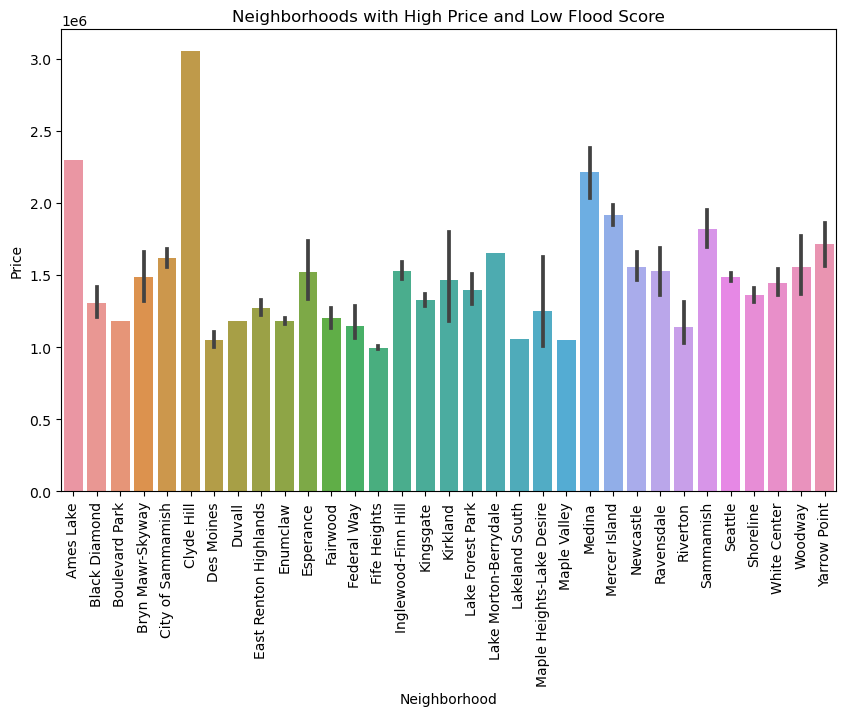

In [87]:
# let's get some visualizations for all our hard work!

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_3, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and Low Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [88]:
# neighborhoods with high prices and high flood scores:

grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))

# Filter the neighborhoods with high price and low flood score
filtered_4 = grouped_4[(grouped['price'] > grouped_3['price'].mean()) & (grouped_3['area_flood_score_min'] > 2)]

# Retrieve the filtered neighborhoods
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Display the filtered neighborhoods
print(neighborhoods_4)

['Algona' 'Ames Lake' 'Auburn' 'Bothell' 'Boulevard Park' 'Brier' 'Burien'
 'Carnation' 'Cottage Lake' 'Covington' 'Des Moines' 'Duvall'
 'East Hill-Meridian' 'East Renton Highlands' 'Eastgate' 'Fairwood'
 'Fall City' 'Federal Way' 'Hobart' 'Inglewood-Finn Hill' 'Issaquah'
 'Kenmore' 'Kent' 'Kingsgate' 'Lake Forest Park' 'Lake Marcel-Stillwater'
 'Lake Morton-Berrydale' 'Lakeland North' 'Lakeland South' 'Lea Hill'
 'Maltby' 'Maple Heights-Lake Desire' 'Maple Valley' 'Mirrormont'
 'Newcastle' 'Newport' 'Normandy Park' 'North Bend' 'Pacific' 'Ravensdale'
 'Redmond' 'Renton' 'Riverbend' 'Riverton' 'Sammamish' 'SeaTac' 'Seattle'
 'Snoqualmie' 'Tanner' 'Union Hill-Novelty Hill' 'West Lake Sammamish'
 'White Center' 'Woodinville']


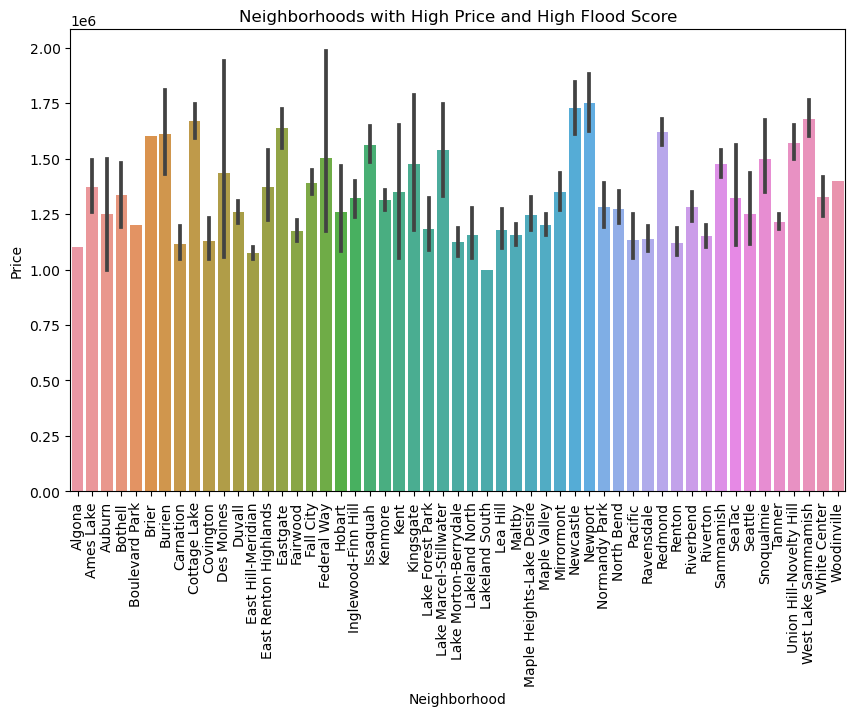

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the grouped_4 dataframe and filter the neighborhoods
grouped_4 = neighborhood_df.groupby('neighborhood').apply(lambda x: x.sort_values(by=['price', 'avg_area_flood_score'], ascending=[False, False]))
filtered_4 = grouped_4[(grouped_4['price'] > grouped_4['price'].mean()) & (grouped_4['area_flood_score_min'] > 2)]
neighborhoods_4 = filtered_4['neighborhood'].unique()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_4, x='neighborhood', y='price')
plt.title('Neighborhoods with High Price and High Flood Score')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


In [90]:
neighborhoods_4

array(['Algona', 'Ames Lake', 'Auburn', 'Bothell', 'Boulevard Park',
       'Brier', 'Burien', 'Carnation', 'Cottage Lake', 'Covington',
       'Des Moines', 'Duvall', 'East Hill-Meridian',
       'East Renton Highlands', 'Eastgate', 'Fairwood', 'Fall City',
       'Federal Way', 'Hobart', 'Inglewood-Finn Hill', 'Issaquah',
       'Kenmore', 'Kent', 'Kingsgate', 'Lake Forest Park',
       'Lake Marcel-Stillwater', 'Lake Morton-Berrydale',
       'Lakeland North', 'Lakeland South', 'Lea Hill', 'Maltby',
       'Maple Heights-Lake Desire', 'Maple Valley', 'Mirrormont',
       'Newcastle', 'Newport', 'Normandy Park', 'North Bend', 'Pacific',
       'Ravensdale', 'Redmond', 'Renton', 'Riverbend', 'Riverton',
       'Sammamish', 'SeaTac', 'Seattle', 'Snoqualmie', 'Tanner',
       'Union Hill-Novelty Hill', 'West Lake Sammamish', 'White Center',
       'Woodinville'], dtype=object)

In [91]:
neighborhood_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city', 'zipcode',
       'floodzones_in_zipcode', 'area_flood_score_max', 'area_flood_score_min',
       'avg_area_flood_score', 'price', 'condition score', 'grade score_2',
       'grade score_3', 'grade score_4', 'grade score_5', 'grade score_6',
       'grade score_7', 'grade score_8', 'grade score_9', 'grade score_10',
       'grade score_11', 'grade score_12', 'has_basement_1', 'on_waterfront_1',
       'near_greenbelt_1', 'view score_1', 'view score_2', 'view score_3',
       'view score_4', 'nuisance_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4',
       'bedrooms_5', 'bedrooms_6', 'bathrooms_0.5', 'bathrooms_1.0',
       'bathrooms_1.5', 'bathrooms_2.0', 'bathrooms_2.5', 'bathrooms_3.0',
       'bathrooms_3.5', 'bathrooms_4.0', 'bathrooms_4.5', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'floors_4.0',
       'coord', 

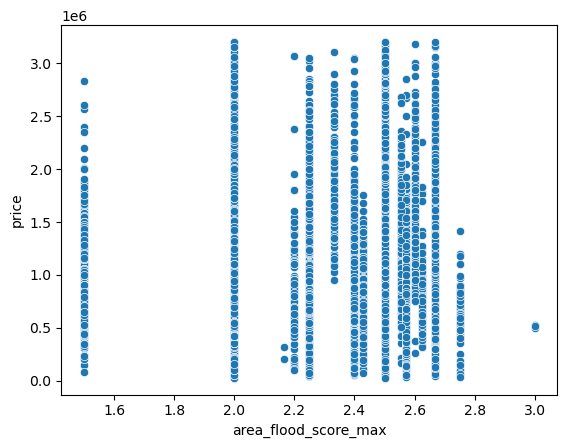

In [92]:
sns.scatterplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

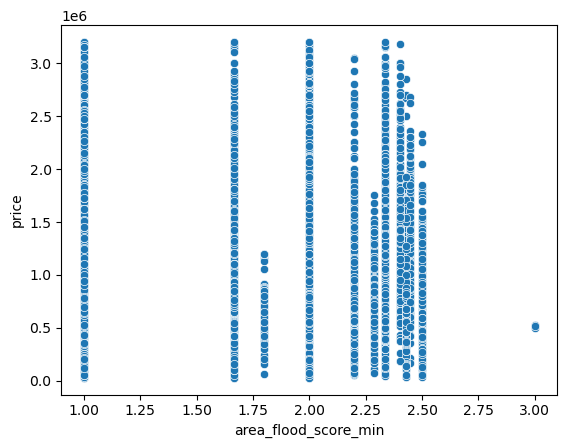

In [93]:
sns.scatterplot(data=neighborhood_df, x='area_flood_score_min', y='price')
plt.show()

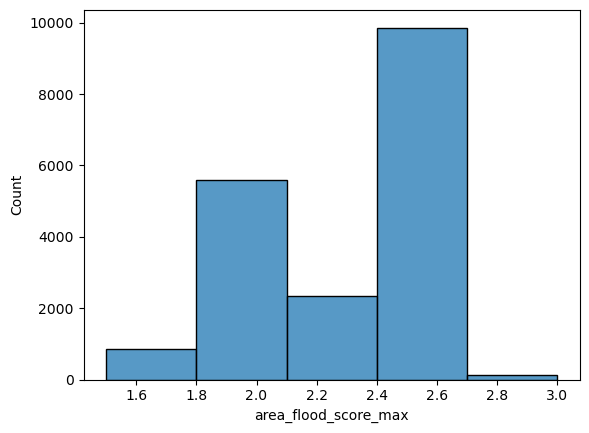

In [94]:
sns.histplot(data=neighborhood_df, x='area_flood_score_max', bins=5)
plt.show()

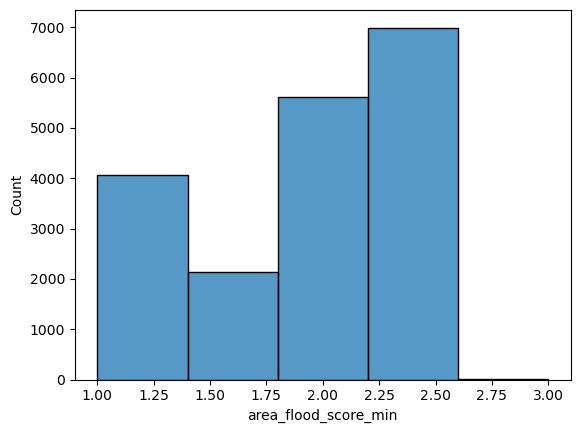

In [95]:
sns.histplot(data=neighborhood_df, x='area_flood_score_min', bins=5)
plt.show()

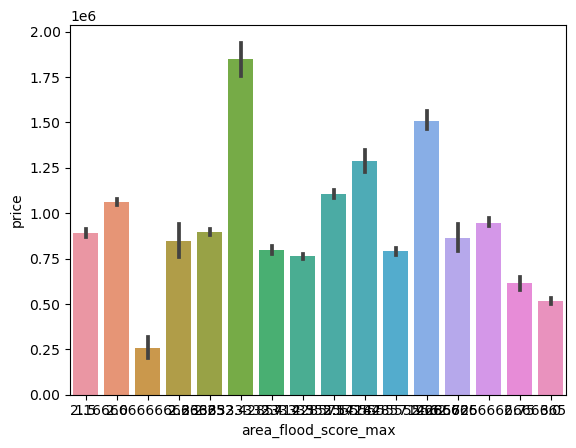

In [96]:
sns.barplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

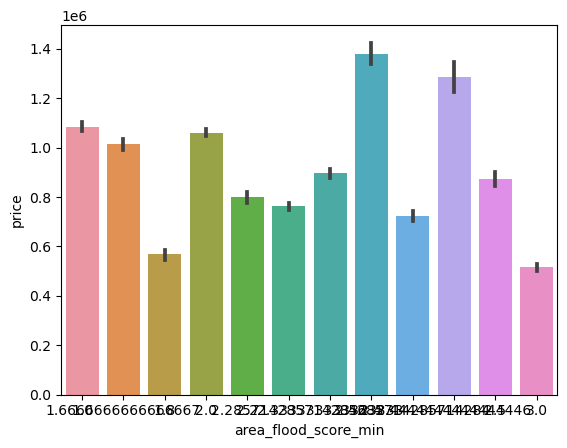

In [97]:
sns.barplot(data=neighborhood_df, x='area_flood_score_min', y='price')
plt.show()

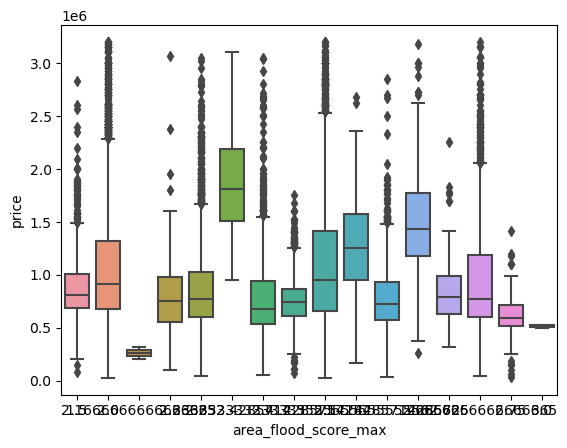

In [98]:
sns.boxplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

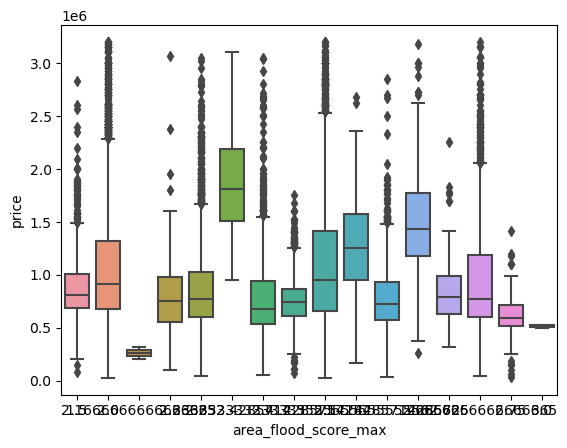

In [99]:
sns.boxplot(data=neighborhood_df, x='area_flood_score_max', y='price')
plt.show()

In [100]:
neighborhood_df.to_csv('cleaned_train_3.csv')
